In [1]:
%pylab inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib
matplotlib.__version__

'2.0.0rc1'

In [3]:
sys.path.insert(0, '../../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2
import gaussianprocessregression as gpr
import designofexperiment as doe
#import pycbcwaveform as pycbcwave
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics
import window
import trainingseteob as traineob
import hybrid

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(taylorf2)
imp.reload(gpr)
imp.reload(doe)
#imp.reload(pycbcwave)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)
imp.reload(window)
imp.reload(traineob)
imp.reload(hybrid)

import constants
imp.reload(constants)
from constants import *

In [4]:
from lalwaveform import dimensionless_td_waveform, dimensionless_fd_waveform
import pycbc.waveform

from scipy import stats
import h5py
import glob

# Methods for the training set

In [5]:
import h5py

def load_eob_training_set_td(orig_filename, mtot=2.0, distance=1.0):
    """Load a compressed waveform set and return a list of Waveform objects.
    """
    # Open original waveform file
    f = h5py.File(orig_filename)
    nwave = len(f['configurations'][:])
    print f.attrs['GenerationSettings']
    print f['configurations_keys'][:]
    print f['data_keys_name'][:]
    
    params = []
    hlist = []
    for i in range(nwave):
        print i, 
        try:
            p, h = traineob.get_waveform_from_training_set(f, i, mtot=mtot, distance=distance)
        except KeyError as e:
            print e
        else:
            # Run if an exception was not raised
            params.append(p)
            hlist.append(h)
        
    return np.array(params), hlist

In [6]:
def geometric_time_domain_waveform(sur, p, delta_t=5.0, foff_i=0.1, foff_f=0.2, plot=False):
    """
    """
    # Evaluate frequency-domain waveform
    htilde = sur.geometric_waveform(p)
    
    # Number of samples needed (nsamp) and associated delta_f
    flow = sur.mf_a
    fhigh = sur.mf_b
    q = p[0]
    min_total_time = 2.0*train.zero_pn_coalescence_time(flow, q)
    nsamp = train.next_pow_2(min_total_time, delta_t)
    delta_f = 1.0/(nsamp*delta_t)
    
    # Window beginning of waveform
    fon_i = htilde.x[0]
    fon_f = 1.1*fon_i
    
    htilde_win = window.window_on(htilde.copy(), fon_i, fon_f, win='planck')
    htilde_win = window.window_off(htilde_win.copy(), foff_i, foff_f, win='planck')
    
    ######## IFFT waveform ##########
    
    # Resample waveform to have spacing delta_f.
    # Pad beginning and end with zeros.
    fs = delta_f*np.arange(nsamp)
    htilde_comp = np.zeros(nsamp, dtype='complex')

    fresamp = fs[(fs>=flow) & (fs<=fhigh)]
    htilde_comp_resamp = htilde_win.interpolate_complex()(fresamp)
    
    ind_i = np.where(fs==fresamp[0])[0][0]
    ind_f = np.where(fs==fresamp[-1])[0][0]
    
    htilde_comp[ind_i:ind_f+1] = htilde_comp_resamp
    
    if plot==True:
        # Plot the padded waveform
        hpad = wave.Waveform.from_complex(fs, htilde_comp)
        fig, (ax1, ax2) = wave.plot_waveforms_fd([hpad])
        ax1.set_yscale('log')
        ax1.set_ylabel(r'$A$')
        ax2.set_ylabel(r'$\Phi$')
        ax2.set_xlabel(r'$Mf$')
        ax1.grid(which='both')
        ax2.grid(which='both')
        ax1.minorticks_on()
        ax2.minorticks_on()
        ax1.set_xlim(1.0e-4, 1.0e-1)
        ax2.set_xlim(1.0e-4, 1.0e-1)
        #ax1.set_ylim(1.0e-2, 1.0e4)
    
    # IFFT
    h_comp = np.fft.ifft(htilde_comp)
    ts = delta_t*np.arange(nsamp, dtype=float)

    # You didn't include the negative frequencies, 
    # so compensate by taking first half and adding to end of second half
    # !!!! Why don't you need to take the complex conjugate of the negative frequency part? !!!!
    h_comp_shift = np.concatenate((h_comp[nsamp//2:], h_comp[:nsamp//2]))
    h_comp_shift /= delta_t
    h = wave.Waveform.from_complex(ts, h_comp_shift)
    
    # Shift t=0 to time of max amplitude
    tmax = traineob.time_at_max_amp(h.x, h.amp)
    h.x -= tmax
    
    # Truncate waveform after t=500M
    tresamp = h.x[h.x<=500.]
    h.resample(tresamp)
    return h

In [7]:
import scipy.interpolate as interpolate

def resample_uniform_in_phase_then_time(h, t_transition, samples_per_cycle, dt, order=2):
    """Resample waveform with spacing uniform in phase at the beginning, 
    then transition to uniform in time at the end.
    """
    t_start = h.x[0]
    t_end = h.x[-1]
    
    phase_mono, i_mono = window.monotonic_increasing_array(h.phase)
    amp_mono = h.amp[i_mono]
    t_mono = h.x[i_mono]
    
    # Interpolate time(phase)
    tofphase = interpolate.UnivariateSpline(phase_mono, t_mono, k=order, s=0)
    ampoft = interpolate.UnivariateSpline(t_mono, amp_mono, k=order, s=0)
    phaseoft = interpolate.UnivariateSpline(t_mono, phase_mono, k=order, s=0)
    
    # Uniform phase samples
    phi_start = phaseoft(t_start)
    phi_transition = phaseoft(t_transition)
    npoints = int(np.ceil((phi_transition - phi_start)*samples_per_cycle/(2.0*np.pi))) + 1
    phase = np.linspace(phi_start, phi_transition, npoints)
    # time samples
    time_a = tofphase(phase)
    time_a[0] = t_start # Make sure this is exactly as requested (not just approximate)
    
    # Uniform time samples
    npoints = int(np.ceil( (t_end-(t_transition+dt))/dt ))
    time_b = np.linspace(t_transition+dt, t_end, npoints)
    
    time = np.concatenate((time_a, time_b))
    amp = ampoft(time)
    phase = phaseoft(time)
    
    return wave.Waveform.from_amp_phase(time, amp, phase)

# Load Surrogate

In [8]:
# nodes_filename = '../../data/TEOBv4_20hz/nodes_corners_lhd.hdf5'
# gp_amp_filename = '../../data/TEOBv4_20hz/gp_spline_amp_corners_lhd.hdf5'
# gp_phase_filename = '../../data/TEOBv4_20hz/gp_spline_phase_corners_lhd.hdf5'
# sur = surrogate.GPSplineSurrogate.load(nodes_filename, gp_amp_filename, gp_phase_filename, order=2, npoints=10000)

# nodes_filename = '../../data/TEOBv4_20hz/nodes_lhd_uncsamp.hdf5'
# gp_amp_filename = '../../data/TEOBv4_20hz/gp_spline_amp_lhd_uncsamp.hdf5'
# gp_phase_filename = '../../data/TEOBv4_20hz/gp_spline_phase_lhd_uncsamp.hdf5'
# sur = surrogate.GPSplineSurrogate.load(nodes_filename, gp_amp_filename, gp_phase_filename, order=3, npoints=10000)

nodes_filename = '../../data/TEOBv4_20hz/nodes_lhd_uncsamp_rand.hdf5'
gp_amp_filename = '../../data/TEOBv4_20hz/gp_spline_amp_lhd_uncsamp_rand.hdf5'
gp_phase_filename = '../../data/TEOBv4_20hz/gp_spline_phase_lhd_uncsamp_rand.hdf5'
sur = surrogate.GPSplineSurrogate.load(nodes_filename, gp_amp_filename, gp_phase_filename, order=3, npoints=10000)

# Load test waveforms

In [9]:
#orig_filename = '../../data/TEOBv4_20hz/TEOB_data_train_corners_lhd.hdf5'
orig_filename = '../../data/TEOBv4_20hz/TEOB_data_test2.hdf5'
params, hlist = load_eob_training_set_td(orig_filename)


        approximant = TEOBv4
        M = 2
        fs = 32768
        iota = 0
        f_min = 20
        distance = 1e+06

        Using lalsimulation version 1.7.3.1
        
['q' 'chi1' 'chi2' 'lambda1' 'lambda2']
['t' 'phi' 'amp']
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 "Unable to open object (Object 'h_83' doesn't exist)"
84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 

# Compare surrogate to original waveform in time domain

[  6.74476891e-01  -4.80768188e-01   3.91854660e-01   2.11106096e+02
   1.43431206e+03]
-16.6922579574 -2.41606406075


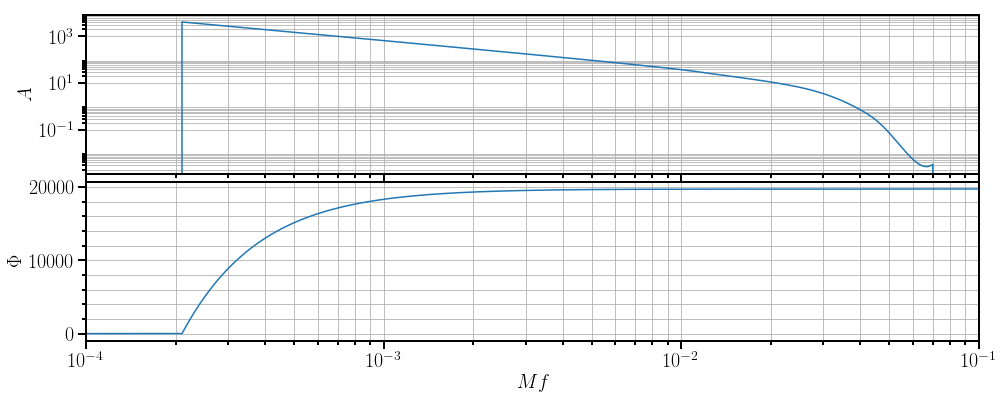

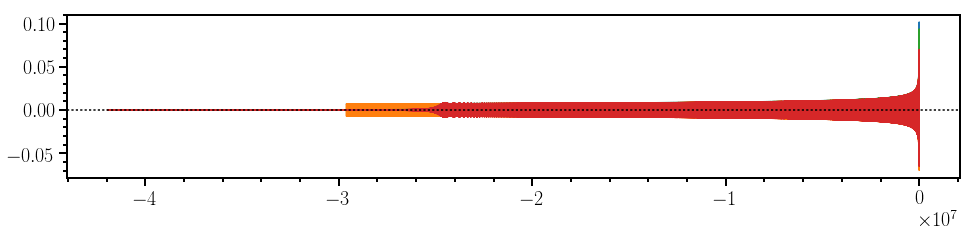

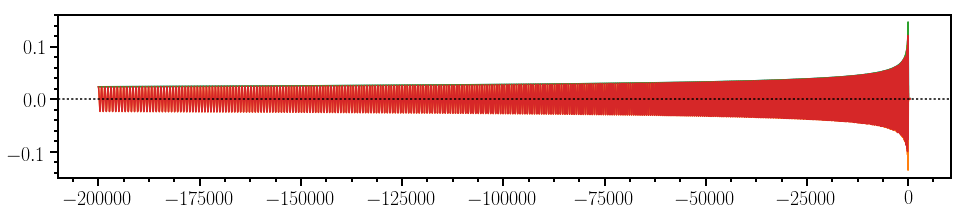

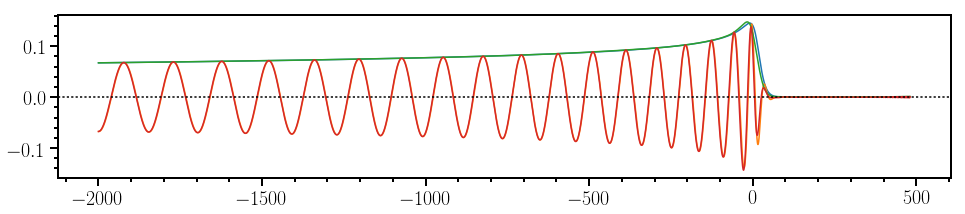

In [11]:
# i = 912+1
# i = 325+1
i = 698

p = params[i]
h = hlist[i]
print p

hsur_td = geometric_time_domain_waveform(sur, p, delta_t=5., foff_i=0.1, foff_f=0.11, plot=True)

# Resample
h_resamp = resample_uniform_in_phase_then_time(h, -1000, 2, 1, order=2)
hsur_td_resamp = resample_uniform_in_phase_then_time(hsur_td, -1000, 2, 1, order=2)

h1 = h_resamp
h2 = hsur_td_resamp
# Often need really long window to get reliable overlap at low frequencies
t1i = -200000
t1f = -100000
taua = -500
taub = 500
# !!! Resample h1 and h2 here to speed up phase shift calculation !!!
taubest, phibest = hybrid.calculate_time_phase_shift(h1, h2, t1i, t1f, taua, taub)
print taubest, phibest
hsur_td_resamp.x += taubest
hsur_td_resamp.phase -= phibest


fig, ax = wave.plot_waveforms([h_resamp, hsur_td_resamp], npoints=100000)
ax.minorticks_on()
#ax.set_ylim(-0.3, 0.3)

fig, ax = wave.plot_waveforms([h_resamp, hsur_td_resamp], xi=t1i, xf=1000, npoints=10000)
ax.minorticks_on()
#ax.set_ylim(-0.3, 0.3)

fig, ax = wave.plot_waveforms([h_resamp, hsur_td_resamp], xi=-2000, xf=1000, npoints=10000)
ax.minorticks_on()
#ax.set_ylim(-0.3, 0.3)

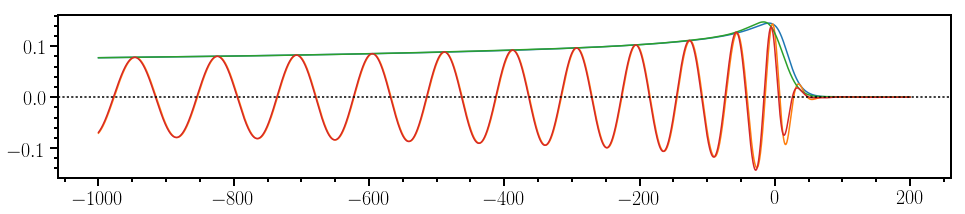

In [12]:
fig, ax = wave.plot_waveforms([h_resamp, hsur_td_resamp], xi=-1000, xf=200, npoints=10000)
ax.minorticks_on()

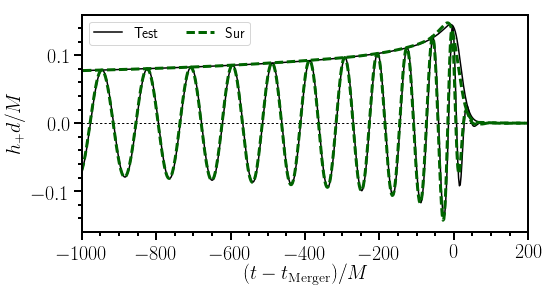

In [26]:
fig, ax = plt.subplots(figsize=(8, 4))
xi = -2000
xf = 200
npoints = 1000
times = np.linspace(xi, xf, npoints)

ax.axhline(0, ls=':', c='k', lw=1)

h = h_resamp
hs = h.interpolate_complex()(times)
ax.plot(times, np.abs(hs), lw=1.5, c='k')
ax.plot(times, np.real(hs), lw=1.5, c='k', label='Test')

h = hsur_td_resamp
hs = h.interpolate_complex()(times)
ax.plot(times, np.abs(hs), lw=3, c='darkgreen', ls='--')
ax.plot(times, np.real(hs), lw=3, c='darkgreen', ls='--', label='Sur')

ax.set_xlim(-1000, 200)
ax.set_ylim(-0.16, 0.16)

ax.minorticks_on()
ax.set_xlabel(r'$(t-t_{\rm Merger})/M$')
ax.set_ylabel(r'$h_+ d / M$')

#ax.grid(axis='both', which='both')
ax.legend(loc='upper left', ncol=2)

#fig.savefig('../../paper/hmaxerror.pdf', format='pdf', transparent=True, bbox_inches='tight')

[  3.80943028e-01  -2.00598993e-01  -1.57797752e-01   3.30990910e+02
   2.52579575e+03]
-27.4382232326 -2.34028893099
[  8.21355002e-01   2.57019001e-01  -1.74100538e-01   2.57145182e+03
   1.67658124e+03]
-19.9123701184 -2.47748964725
[  7.34627427e-01  -2.28641263e-01   4.02022735e-01   1.08811309e+03
   2.78079464e+03]
-16.1809452203 2.89230988192


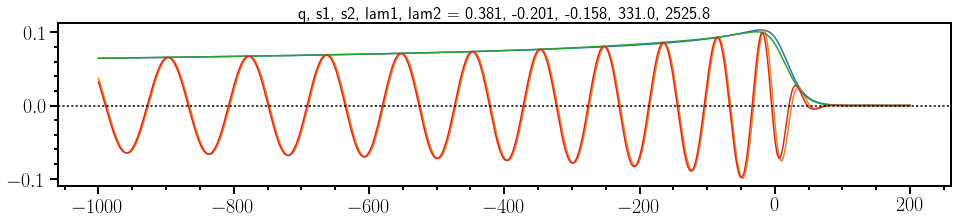

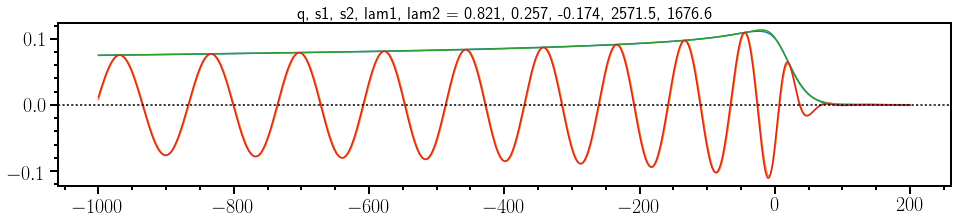

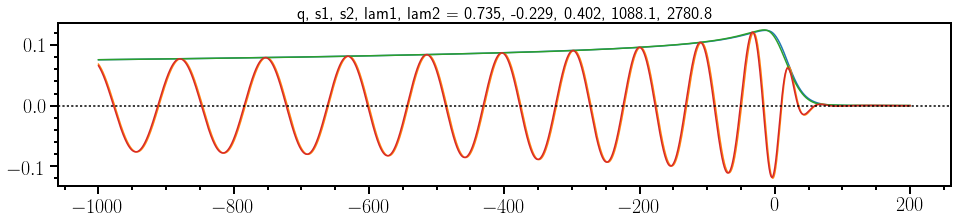

In [27]:
for i in range(3):
    p = params[i]
    h = hlist[i]
    print p

    hsur_td = geometric_time_domain_waveform(sur, p, delta_t=5., foff_i=0.1, foff_f=0.11, plot=False)
    
    # Resample
    h_resamp = resample_uniform_in_phase_then_time(h, -1000, 2, 1, order=2)
    hsur_td_resamp = resample_uniform_in_phase_then_time(hsur_td, -1000, 2, 1, order=2)
    
    h1 = h_resamp
    h2 = hsur_td_resamp
    # Often need really long window to get reliable overlap at low frequencies
    t1i = -200000
    t1f = -100000
    taua = -500
    taub = 500
    taubest, phibest = hybrid.calculate_time_phase_shift(h1, h2, t1i, t1f, taua, taub)
    print taubest, phibest
    hsur_td_resamp.x += taubest
    hsur_td_resamp.phase -= phibest

    fig, ax = wave.plot_waveforms([h_resamp, hsur_td_resamp], xi=-1000, xf=200, npoints=10000)
    title = 'q, s1, s2, lam1, lam2 = {:.3}, {:.3}, {:.3}, {:.1f}, {:.1f}'.format(p[0], p[1], p[2], p[3], p[4])
    ax.set_title(title)
    ax.minorticks_on()

# Compare surrogate to training set waveforms

These should agree almost exactly

In [28]:
orig_filename = '../../data/TEOBv4_40hz/TEOB_data_train_corners_lhd.hdf5'
#orig_filename = '../../data/TEOBv4_40hz/TEOB_data_test2.hdf5'
params, hlist = load_eob_training_set_td(orig_filename)


        approximant = TEOBv4
        M = 2
        fs = 32768
        iota = 0
        f_min = 40
        distance = 1e+06

        Using lalsimulation version 1.7.3.1
        
['q' 'chi1' 'chi2' 'lambda1' 'lambda2']
['t' 'phi' 'amp']
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159


In [29]:
params[14]

array([  3.33333333e-01,   5.00000000e-01,   5.00000000e-01,
         5.00000000e+03,   0.00000000e+00])

[  3.33333333e-01   5.00000000e-01   5.00000000e-01   5.00000000e+03
   0.00000000e+00]
2.17059536902 -0.808851204066


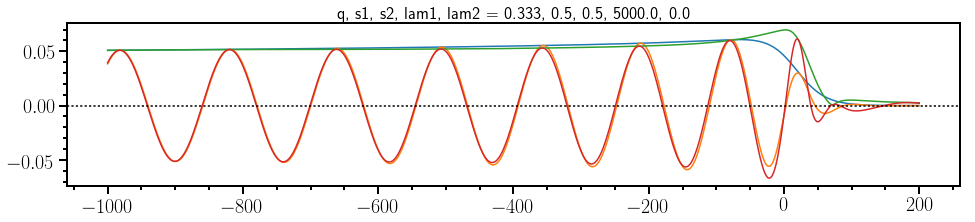

In [30]:
i = 14
p = params[i]
h = hlist[i]
print p

hsur_td = geometric_time_domain_waveform(sur, p, delta_t=5., foff_i=0.1, foff_f=0.11, plot=False)

# Resample
h_resamp = resample_uniform_in_phase_then_time(h, -1000, 2, 1, order=2)
hsur_td_resamp = resample_uniform_in_phase_then_time(hsur_td, -1000, 2, 1, order=2)

h1 = h_resamp
h2 = hsur_td_resamp
# Often need really long window to get reliable overlap at low frequencies
t1i = -200000
t1f = -100000
taua = -500
taub = 500
taubest, phibest = hybrid.calculate_time_phase_shift(h1, h2, t1i, t1f, taua, taub)
print taubest, phibest
hsur_td_resamp.x += taubest
hsur_td_resamp.phase -= phibest

fig, ax = wave.plot_waveforms([h_resamp, hsur_td_resamp], xi=-1000, xf=200, npoints=10000)
title = 'q, s1, s2, lam1, lam2 = {:.3}, {:.3}, {:.3}, {:.1f}, {:.1f}'.format(p[0], p[1], p[2], p[3], p[4])
ax.set_title(title)
ax.minorticks_on()

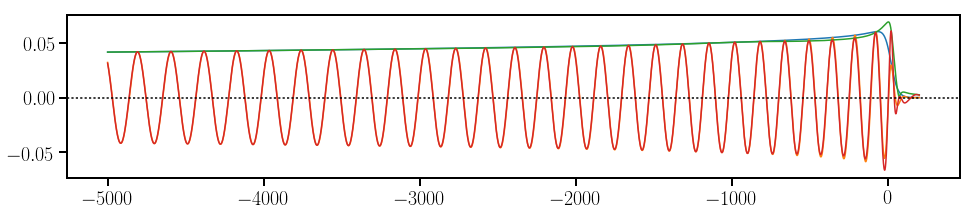

In [31]:
fig, ax = wave.plot_waveforms([h_resamp, hsur_td_resamp], xi=-5000, xf=200, npoints=10000)

[ 0.33333333 -0.5        -0.5         0.          0.        ]
-5.44816329557 0.389086979947
[  3.33333333e-01  -5.00000000e-01  -5.00000000e-01   0.00000000e+00
   5.00000000e+03]
-8.88037219653 0.369000827262
[  3.33333333e-01  -5.00000000e-01  -5.00000000e-01   5.00000000e+03
   0.00000000e+00]
-30.3424556441 0.194096645766
[  3.33333333e-01  -5.00000000e-01  -5.00000000e-01   5.00000000e+03
   5.00000000e+03]
-21.9543307786 0.140340108876
[ 0.33333333 -0.5         0.5         0.          0.        ]
-7.04920202015 -3.04468299354
[  3.33333333e-01  -5.00000000e-01   5.00000000e-01   0.00000000e+00
   5.00000000e+03]
-10.3034525258 -3.07779622959
[  3.33333333e-01  -5.00000000e-01   5.00000000e-01   5.00000000e+03
   0.00000000e+00]
-32.1922428067 3.02883982189
[  3.33333333e-01  -5.00000000e-01   5.00000000e-01   5.00000000e+03
   5.00000000e+03]
-30.7365472225 3.02430784133
[ 0.33333333  0.5        -0.5         0.          0.        ]
-11.2519814348 -2.54432484207
[  3.33333333e-01 

/Users/lackey/Library/Python/2.7/lib/python/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


-23.5635367728 -2.57390367813
[  1.00000000e+00  -5.00000000e-01   5.00000000e-01   5.00000000e+03
   0.00000000e+00]
-23.7293654998 -2.57382074794
[  1.00000000e+00  -5.00000000e-01   5.00000000e-01   5.00000000e+03
   5.00000000e+03]
-13.7130455396 -2.60965768027
[ 1.   0.5 -0.5  0.   0. ]
-11.4814084115 -2.52248547319
[  1.00000000e+00   5.00000000e-01  -5.00000000e-01   0.00000000e+00
   5.00000000e+03]
-23.7280495547 -2.57380029849
[  1.00000000e+00   5.00000000e-01  -5.00000000e-01   5.00000000e+03
   0.00000000e+00]
-23.5661046629 -2.57395423764
[  1.00000000e+00   5.00000000e-01  -5.00000000e-01   5.00000000e+03
   5.00000000e+03]
-14.1128592479 -2.60823301032
[ 1.   0.5  0.5  0.   0. ]
-14.2398407596 2.66373490537
[  1.00000000e+00   5.00000000e-01   5.00000000e-01   0.00000000e+00
   5.00000000e+03]
-17.8432098666 2.58928015577
[  1.00000000e+00   5.00000000e-01   5.00000000e-01   5.00000000e+03
   0.00000000e+00]
-17.6182997911 2.58911002503
[  1.00000000e+00   5.00000000e-0

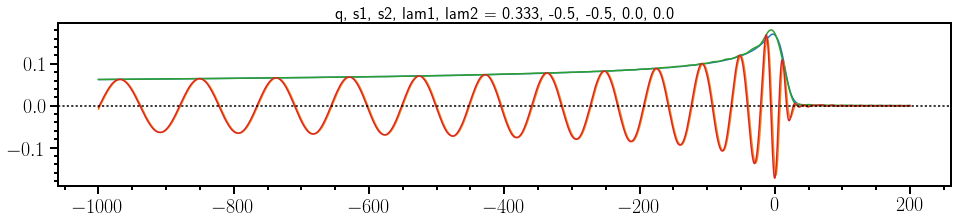

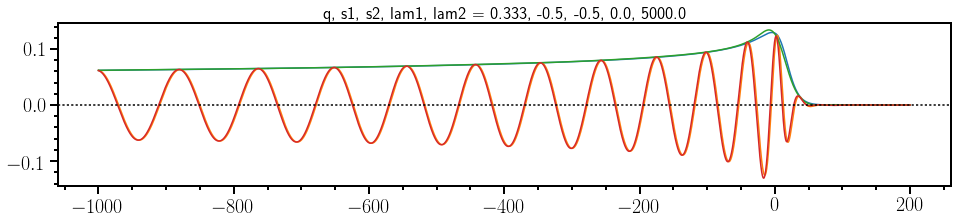

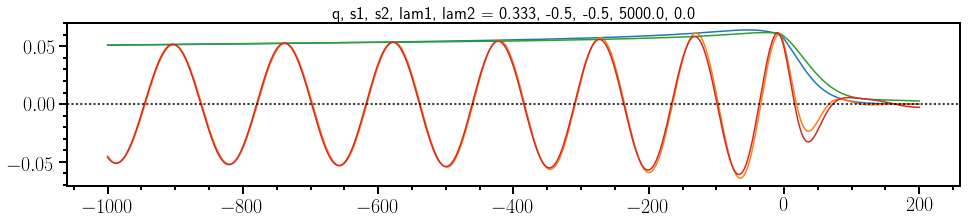

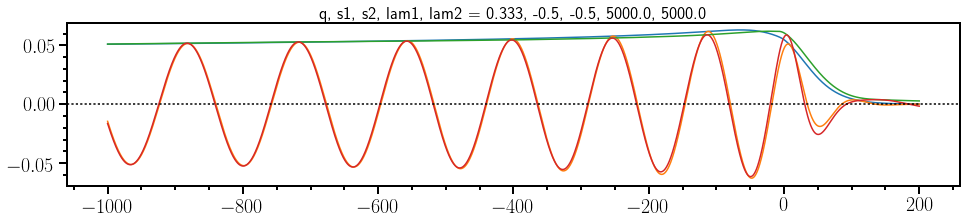

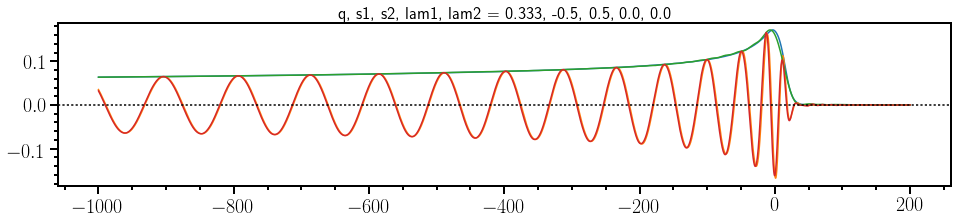

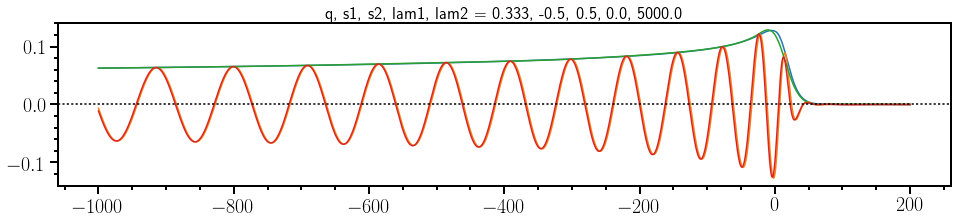

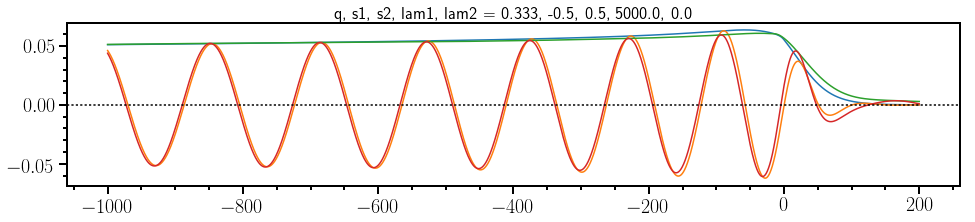

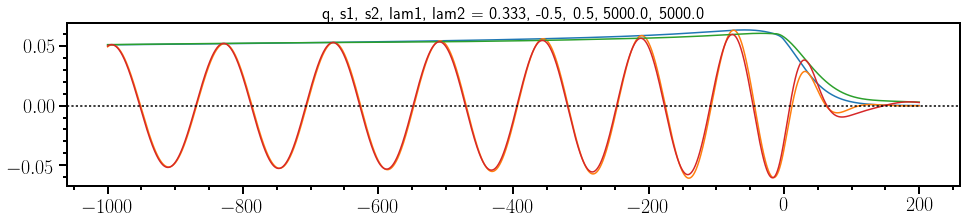

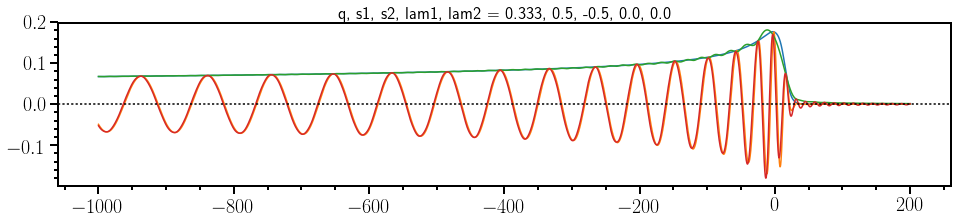

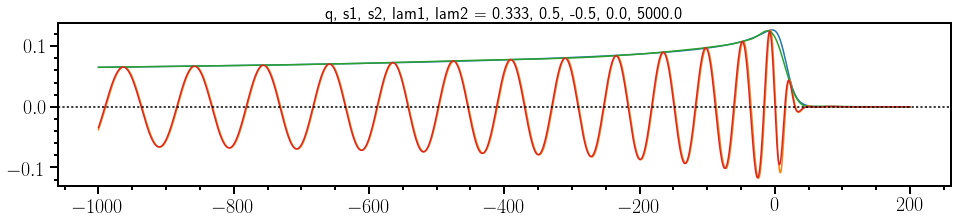

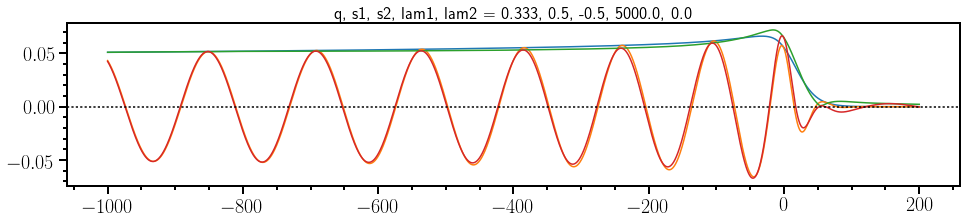

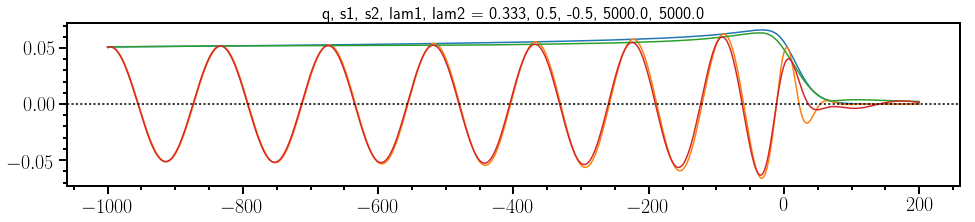

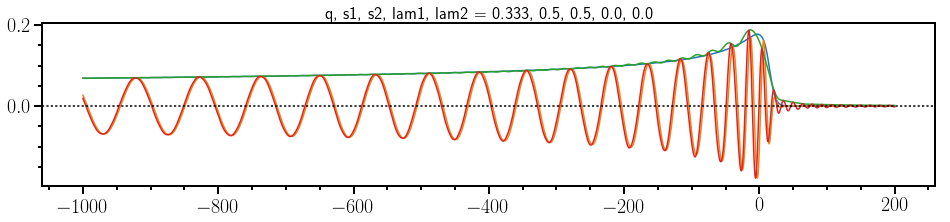

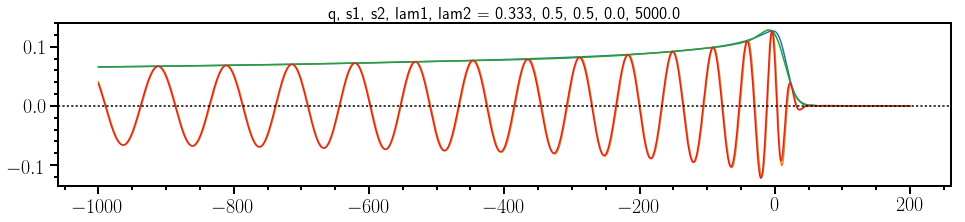

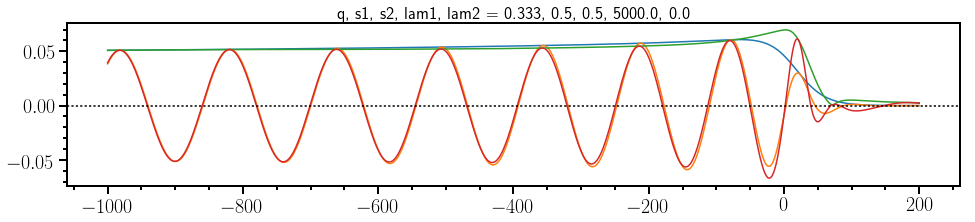

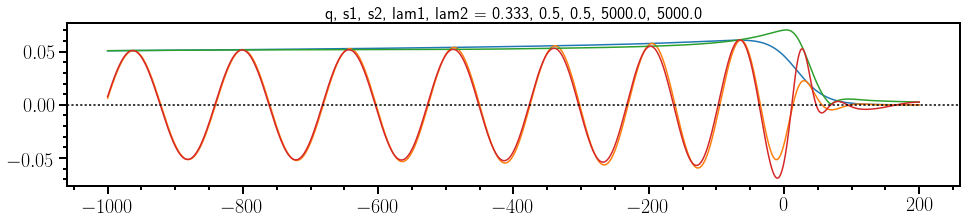

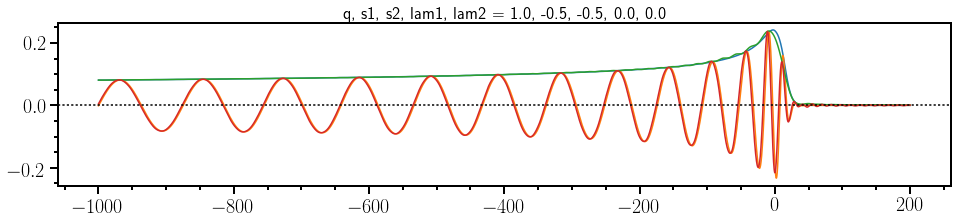

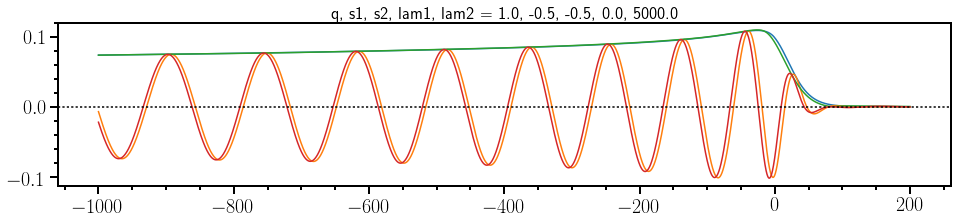

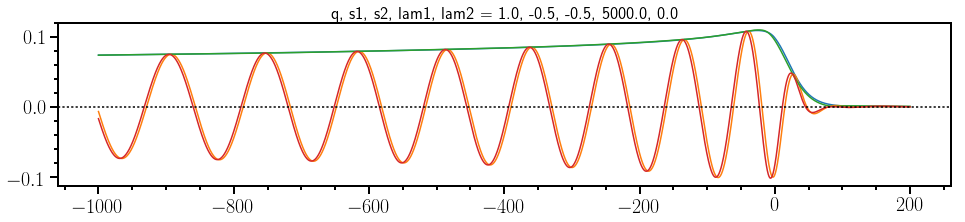

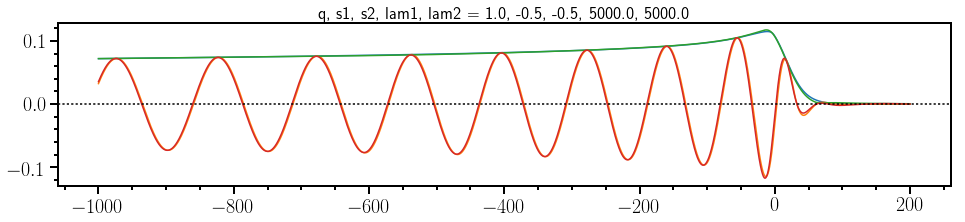

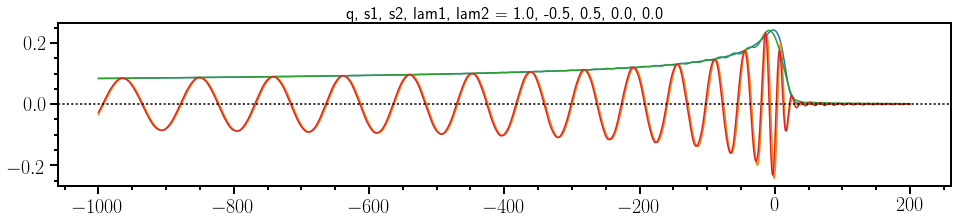

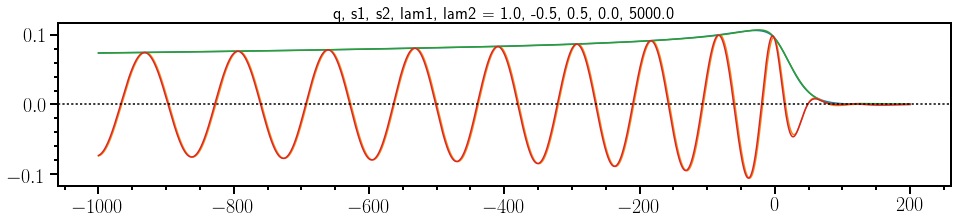

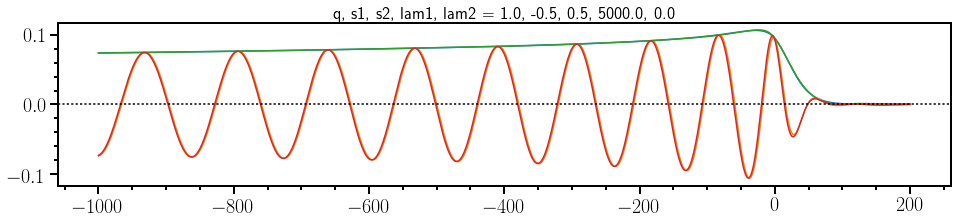

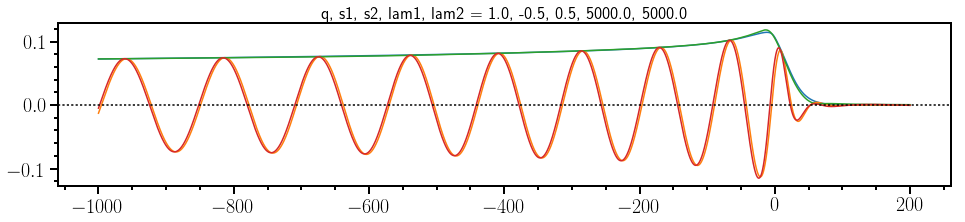

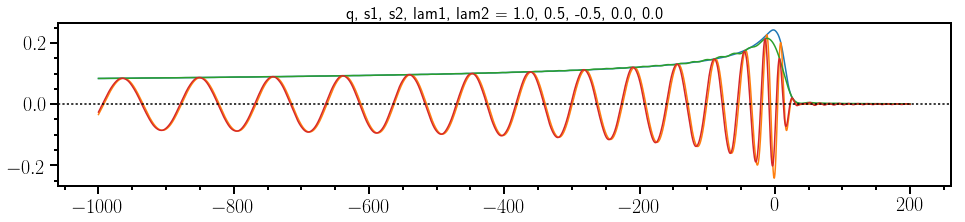

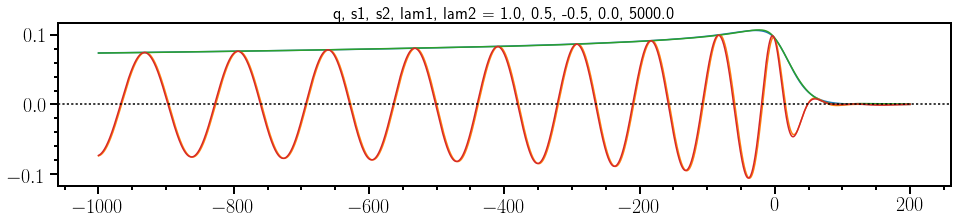

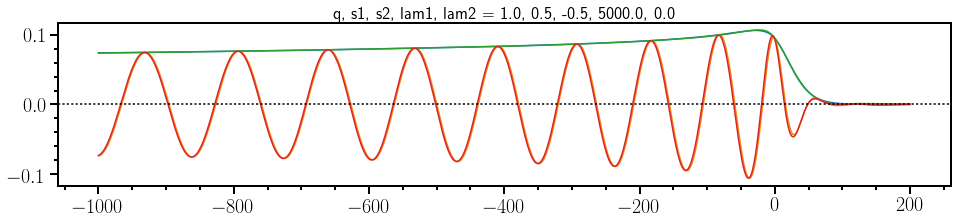

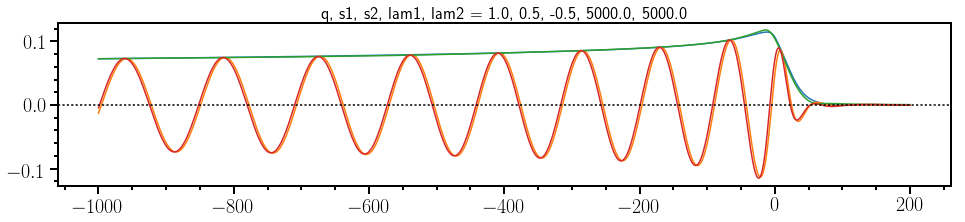

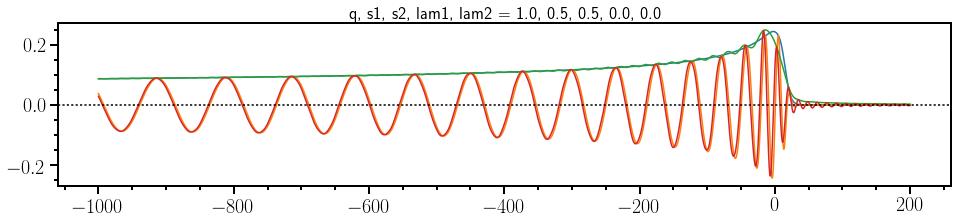

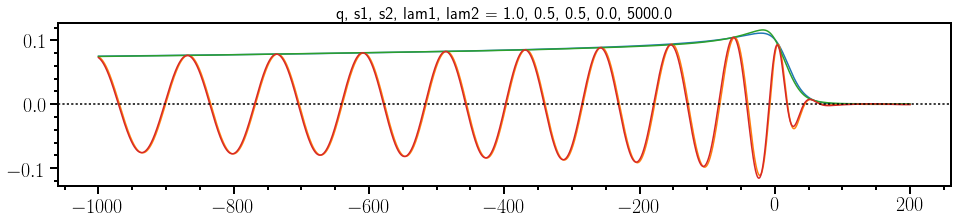

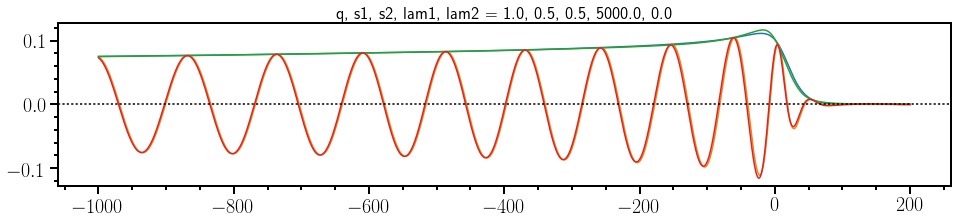

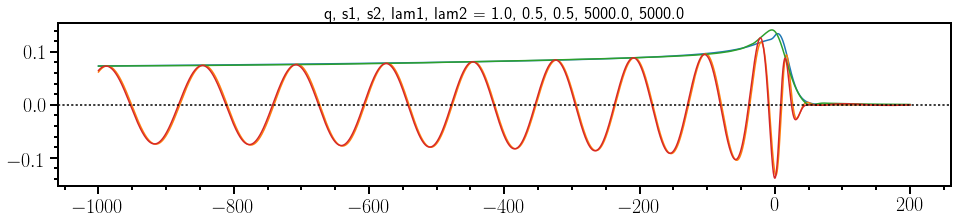

In [32]:
for i in range(32):
    p = params[i]
    h = hlist[i]
    print p

    hsur_td = geometric_time_domain_waveform(sur, p, delta_t=5., foff_i=0.1, foff_f=0.11, plot=False)
    
    # Resample
    h_resamp = resample_uniform_in_phase_then_time(h, -1000, 2, 1, order=2)
    hsur_td_resamp = resample_uniform_in_phase_then_time(hsur_td, -1000, 2, 1, order=2)
    
    h1 = h_resamp
    h2 = hsur_td_resamp
    # Often need really long window to get reliable overlap at low frequencies
    t1i = -200000
    t1f = -100000
    taua = -500
    taub = 500
    taubest, phibest = hybrid.calculate_time_phase_shift(h1, h2, t1i, t1f, taua, taub)
    print taubest, phibest
    hsur_td_resamp.x += taubest
    hsur_td_resamp.phase -= phibest

    fig, ax = wave.plot_waveforms([h_resamp, hsur_td_resamp], xi=-1000, xf=200, npoints=10000)
    title = 'q, s1, s2, lam1, lam2 = {:.3}, {:.3}, {:.3}, {:.1f}, {:.1f}'.format(p[0], p[1], p[2], p[3], p[4])
    ax.set_title(title)
    ax.minorticks_on()